In [1]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 38.0 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.2
    Uninstalling transformers-4.44.2:
      Successfully uninstalled transformers-4.44.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 8.6 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.34.2
    Uninstalling accelerate-0.34.2:
      Successfully uninstalled accelerate-0.34.2
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━

In [2]:
import pandas as pd
from datasets import load_dataset

In [4]:
data = load_dataset('ncbi_disease',trust_remote_code=True)
data

Generating train split:   0%|          | 0/5433 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/924 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/941 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 5433
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 924
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 941
    })
})

In [5]:
data['train'].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-Disease', 'I-Disease'], id=None), length=-1, id=None)}

In [6]:
pd.DataFrame(data['train'][:])[['tokens', 'ner_tags']].iloc[0]

,0
tokens,"[Identification, of, APC2, ,, a, homologue, of..."
ner_tags,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0]"


In [7]:
tags = data['train'].features['ner_tags'].feature

index2tag = {idx:tag for idx, tag in enumerate(tags.names)}
tag2index = {tag:idx for idx, tag in enumerate(tags.names)}

In [8]:
index2tag

{0: 'O', 1: 'B-Disease', 2: 'I-Disease'}

In [9]:
tags.int2str(2)

'I-Disease'

In [10]:
def create_tag_names(batch):
  tag_name = {'ner_tags_str': [tags.int2str(idx) for idx in batch['ner_tags']]}
  return tag_name

In [11]:
data = data.map(create_tag_names)

Map:   0%|          | 0/5433 [00:00<?, ? examples/s]

Map:   0%|          | 0/924 [00:00<?, ? examples/s]

Map:   0%|          | 0/941 [00:00<?, ? examples/s]

In [12]:
pd.DataFrame(data['train'][:])[['tokens', 'ner_tags', 'ner_tags_str']].iloc[0]

,0
tokens,"[Identification, of, APC2, ,, a, homologue, of..."
ner_tags,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0]"
ner_tags_str,"[O, O, O, O, O, O, O, O, B-Disease, I-Disease,..."


# ***EDA***

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("ncbi_disease")
df = pd.DataFrame(dataset["train"])

# Data Exploration
print("Dataset Information:")
print(df.info())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5433 entries, 0 to 5432
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5433 non-null   object
 1   tokens    5433 non-null   object
 2   ner_tags  5433 non-null   object
dtypes: object(3)
memory usage: 127.5+ KB
None


In [ ]:
print("Summary Statistics:")
print(df.describe())

Summary Statistics:
          id            tokens  \
count   5433              5433   
unique  5433              5401   
top     5432  [CONCLUSIONS, .]   
freq       1                 4   

                                                 ner_tags  
count                                                5433  
unique                                               2438  
top     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
freq                                                  107  


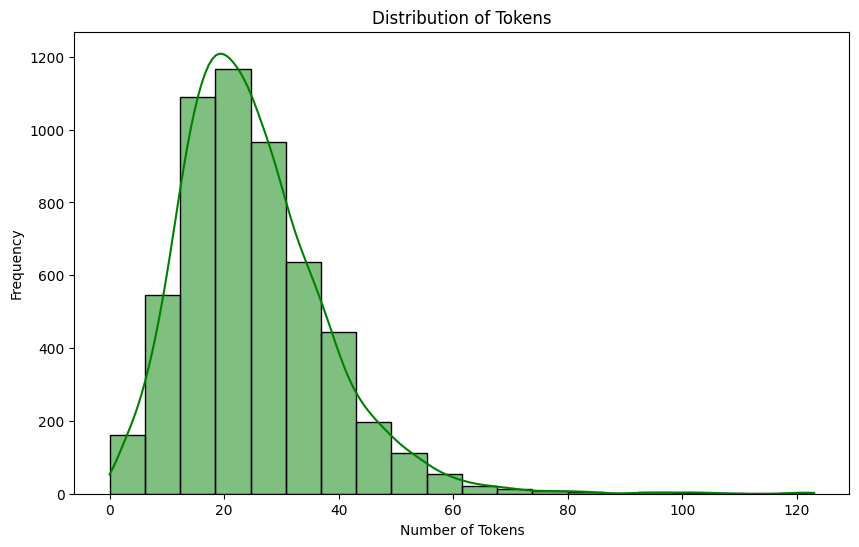

In [ ]:
# Visualization with Seaborn
# Example plots: Distribution of tokens
plt.figure(figsize=(10, 6))
sns.histplot(df['tokens'].apply(len), bins=20, kde=True, color='green')
plt.title('Distribution of Tokens')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

<ipython-input-20-533f87adff46>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='token', data=df_flat, palette=custom_palette, order=df_flat['token'].value_counts().index[:30])


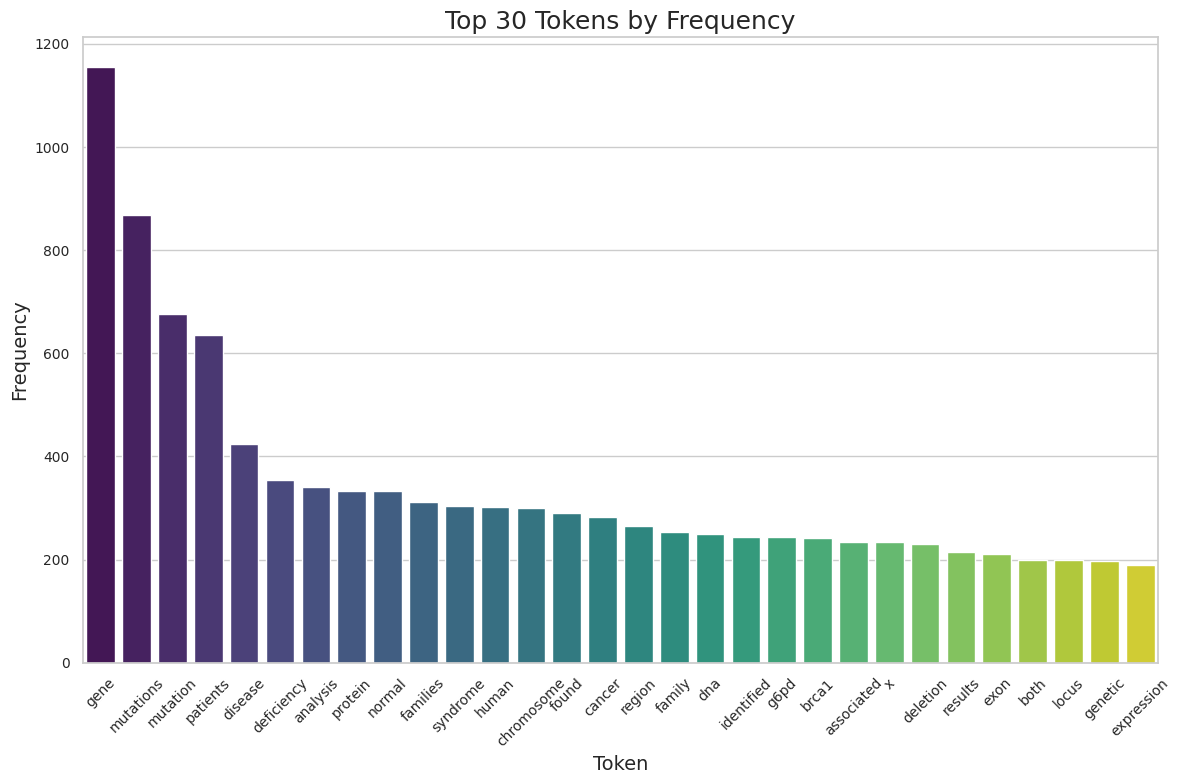

In [ ]:
import string

# Flatten the 'tokens' column and remove specified words
flat_tokens = [''.join(token.translate(str.maketrans('', '', string.punctuation)).lower().split()) for sublist in df['tokens'] for token in sublist if token.lower() not in ['the', 'of', 'in', 'and', 'to', 'is', 'for', 'that', 'at', 'an', 'a', 'this', 'have', 'from','with','was','by','we','were','these','as','or','are','be','on','1','been','not','two','which','one','has','2','3','5','all','but']]

# Remove empty strings
flat_tokens = [token for token in flat_tokens if token]

# Create a new DataFrame with flattened tokens
df_flat = pd.DataFrame({'token': flat_tokens})

# Set the style and palette for the plot
sns.set(style='whitegrid')
custom_palette = sns.color_palette("viridis", 30)  # Choose 30 colors from the Viridis color palette

# Plot the count of each token
plt.figure(figsize=(12, 8))
ax = sns.countplot(x='token', data=df_flat, palette=custom_palette, order=df_flat['token'].value_counts().index[:30])
ax.set_title('Top 30 Tokens by Frequency', fontsize=18)
ax.set_xlabel('Token', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.tick_params(axis='x', labelrotation=45, labelsize=10)
ax.tick_params(axis='y', labelsize=10)
plt.tight_layout()
plt.show()

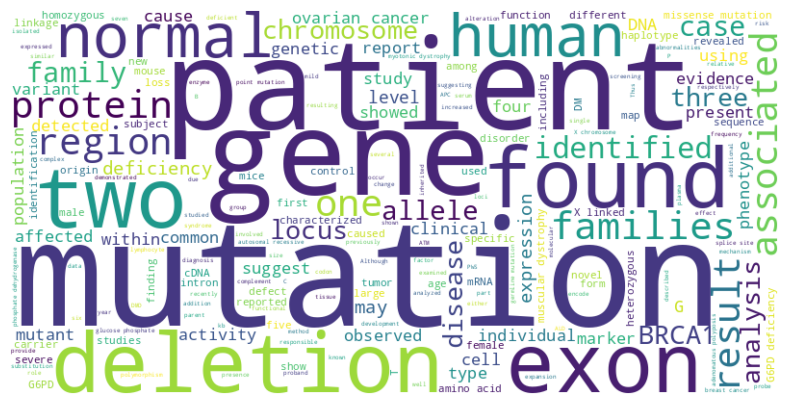

In [ ]:
from wordcloud import WordCloud

# Load the dataset
dataset = load_dataset("ncbi_disease")

# Access the text data from the dataset
text_data = dataset["train"]["tokens"]

# Flatten the list of tokens into a single string
text = ' '.join([' '.join(tokens) for tokens in text_data])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axis
plt.show()

<ipython-input-22-6445628a9b2c>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='ner_tag', data=df_flat_ner_tags, palette='viridis')


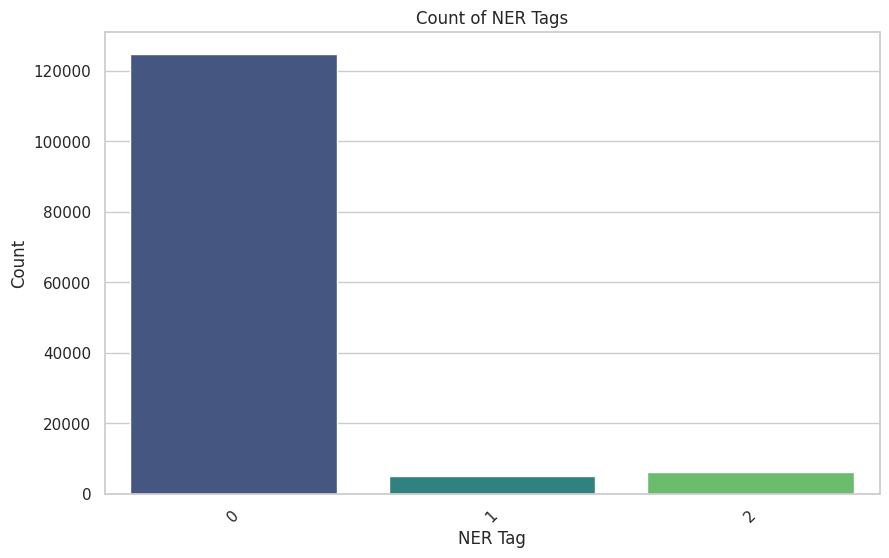

In [ ]:
# Flatten the 'ner_tags' column
flat_ner_tags = [tag for sublist in df['ner_tags'] for tag in sublist]

# Create a new DataFrame with flattened NER tags
df_flat_ner_tags = pd.DataFrame({'ner_tag': flat_ner_tags})

# Plot the count of each NER tag
plt.figure(figsize=(10, 6))
sns.countplot(x='ner_tag', data=df_flat_ner_tags, palette='viridis')
plt.title('Count of NER Tags')
plt.xlabel('NER Tag')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

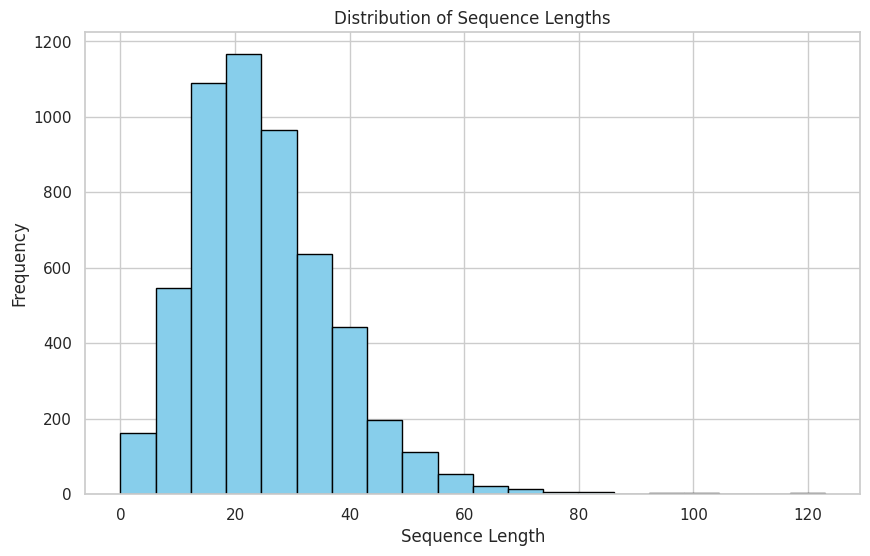

In [ ]:
# Calculate sequence lengths
df['sequence_length'] = df['tokens'].apply(len)

# Plot the distribution of sequence lengths
plt.figure(figsize=(10, 6))
plt.hist(df['sequence_length'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

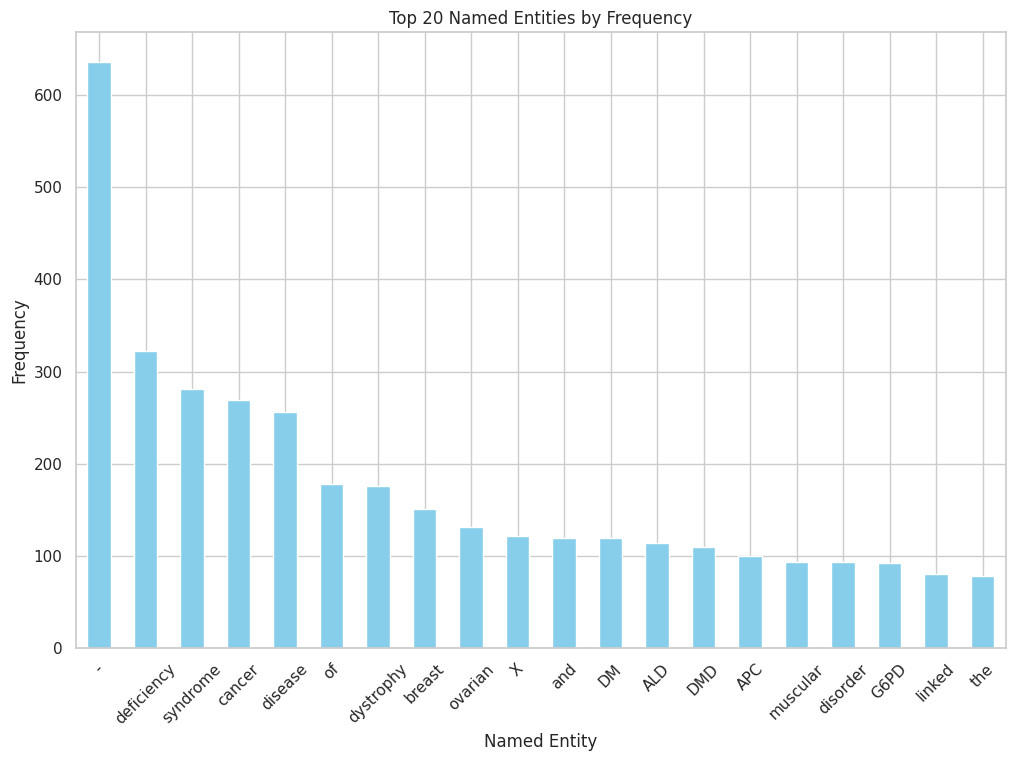

In [ ]:
# Flatten the 'tokens' and 'ner_tags' columns
flat_tokens = [token for sublist in df['tokens'] for token in sublist]
flat_ner_tags = [tag for sublist in df['ner_tags'] for tag in sublist]

# Extract named entities and their corresponding tokens
entities = []
for i, tag in enumerate(flat_ner_tags):
    if tag != 0:
        entities.append(flat_tokens[i])

# Count the frequency of each named entity
entity_counts = pd.Series(entities).value_counts()

# Plot the frequency of named entities
plt.figure(figsize=(12, 8))
entity_counts[:20].plot(kind='bar', color='skyblue')
plt.title('Top 20 Named Entities by Frequency')
plt.xlabel('Named Entity')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# # Flatten the 'tokens' and 'ner_tags' columns
# flat_tokens = [token for sublist in df['tokens'] for token in sublist]
# flat_ner_tags = [tag for sublist in df['ner_tags'] for tag in sublist]

# # Create a new DataFrame with flattened tokens and NER tags
# df_flat = pd.DataFrame({'token': flat_tokens, 'ner_tag': flat_ner_tags})

# # Plot the frequency of each token based on its NER tag
# plt.figure(figsize=(12, 8))
# sns.countplot(x='token', hue='ner_tag', data=df_flat, palette='viridis')
# plt.title('Frequency of Tokens by NER Tag')
# plt.xlabel('Token')
# plt.ylabel('Frequency')
# plt.xticks(rotation=45)
# plt.legend(title='NER Tag')
# plt.show()

## Model Building

In [14]:
from transformers import AutoTokenizer

model_checkpoint = "distilbert-base-cased"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [15]:
tokenizer.is_fast

True

In [16]:
inputs = data['train'][0]['tokens']
inputs = tokenizer(inputs, is_split_into_words=True)
print(inputs.tokens())

['[CLS]', 'I', '##dent', '##ification', 'of', 'AP', '##C', '##2', ',', 'a', 'ho', '##mo', '##logue', 'of', 'the', 'ad', '##eno', '##mat', '##ous', 'p', '##oly', '##po', '##sis', 'co', '##li', 't', '##umour', 'suppress', '##or', '.', '[SEP]']


In [17]:
print(data['train'][0]['tokens'])
print(data['train'][0]['ner_tags_str'])

['Identification', 'of', 'APC2', ',', 'a', 'homologue', 'of', 'the', 'adenomatous', 'polyposis', 'coli', 'tumour', 'suppressor', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Disease', 'I-Disease', 'I-Disease', 'I-Disease', 'O', 'O']


In [18]:
inputs.word_ids()

[None,
 0,
 0,
 0,
 1,
 2,
 2,
 2,
 3,
 4,
 5,
 5,
 5,
 6,
 7,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 10,
 10,
 11,
 11,
 12,
 12,
 13,
 None]

In [19]:
# method to align these tokens
def align_labels_with_tokens(labels, word_ids):
  new_labels = []
  current_word=None
  for word_id in word_ids:
    if word_id != current_word:
      current_word = word_id
      label = -100 if word_id is None else labels[word_id]
      new_labels.append(label)

    elif word_id is None:
      new_labels.append(-100)

    else:
      label = labels[word_id]

      if label%2==1:
        label = label + 1
      new_labels.append(label)

  return new_labels

In [20]:
labels = data['train'][0]['ner_tags']
word_ids = inputs.word_ids()
print(labels, word_ids)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0] [None, 0, 0, 0, 1, 2, 2, 2, 3, 4, 5, 5, 5, 6, 7, 8, 8, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 12, 12, 13, None]


In [21]:
align_labels_with_tokens(labels, word_ids)

[-100,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 -100]

In [22]:
def tokenize_and_align_labels(examples):
  tokenized_inputs = tokenizer(examples['tokens'], truncation=True, is_split_into_words=True)

  all_labels = examples['ner_tags']

  new_labels = []
  for i, labels in enumerate(all_labels):
    word_ids = tokenized_inputs.word_ids(i)
    new_labels.append(align_labels_with_tokens(labels, word_ids))

  tokenized_inputs['labels'] = new_labels

  return tokenized_inputs

In [23]:
tokenized_datasets = data.map(tokenize_and_align_labels, batched=True, remove_columns=data['train'].column_names)

Map:   0%|          | 0/5433 [00:00<?, ? examples/s]

Map:   0%|          | 0/924 [00:00<?, ? examples/s]

Map:   0%|          | 0/941 [00:00<?, ? examples/s]

In [24]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 5433
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 924
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 941
    })
})

## Data Collation and Metrics


In [25]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [26]:
batch = data_collator([tokenized_datasets['train'][i] for i in range(2)])
batch

{'input_ids': tensor([[  101,   146, 11951,  5783,  1104, 10997,  1658,  1477,   117,   170,
         16358,  3702, 12733,  1104,  1103,  8050, 26601, 21943,  2285,   185,
         23415,  5674,  4863,  1884,  2646,   189, 27226, 17203,  1766,   119,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101,  1109,  8050, 26601, 21943,  2285,   185, 23415,  5674,  4863,
          1884,  2646,   113, 10997,  1658,   114,   189, 27226,   118, 17203,
          1766,  4592,  7451,  1103,   160,  2227, 25498, 13548,  1118,  5071,
           170,  2703,  1114,   176,  1193,  2528,  4915,   188, 26588,  6530,
         24779,   124, 16632,  1161,   113,   144,  1708,  2428,   118,   124,
         16632,  1161,   114,   117,   170, 16594,   120,  5880,  1394, 

## Metrics

In [27]:
!pip install seqeval
!pip install evaluate

import evaluate
metric = evaluate.load('seqeval')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=9ff41ac51017a61ff6d8e38245cc0ecbbee5d4d7db7485a36dd72d60491e1df4
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.9 MB/s eta 0:00:00


In [28]:
ner_feature = data['train'].features['ner_tags']
ner_feature

Sequence(feature=ClassLabel(names=['O', 'B-Disease', 'I-Disease'], id=None), length=-1, id=None)

In [29]:
label_names = ner_feature.feature.names
label_names

['O', 'B-Disease', 'I-Disease']

In [30]:
labels = data['train'][0]['ner_tags']
labels = [label_names[i] for i in labels]
labels

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Disease',
 'I-Disease',
 'I-Disease',
 'I-Disease',
 'O',
 'O']

In [31]:
predictions = labels.copy()
predictions[11] = "O"

metric.compute(predictions=[predictions], references=[labels])

{'Disease': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1},
 'overall_precision': 0.0,
 'overall_recall': 0.0,
 'overall_f1': 0.0,
 'overall_accuracy': 0.9285714285714286}

In [32]:
import numpy as np

def compute_metrics(eval_preds):
  logits, labels = eval_preds

  predictions = np.argmax(logits, axis=-1)

  true_labels = [[label_names[l] for l in label if l!=-100] for label in labels]

  true_predictions = [[label_names[p] for p,l in zip(prediction, label) if l!=-100]
                      for prediction, label in zip(predictions, labels)]

  all_metrics = metric.compute(predictions=true_predictions, references=true_labels)

  return {"precision": all_metrics['overall_precision'],
          "recall": all_metrics['overall_recall'],
          "f1": all_metrics['overall_f1'],
          "accuracy": all_metrics['overall_accuracy']}

## Model Training

In [33]:
id2label = {i:label for i, label in enumerate(label_names)}
label2id = {label:i for i, label in enumerate(label_names)}

In [34]:
print(id2label)

{0: 'O', 1: 'B-Disease', 2: 'I-Disease'}


In [35]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
                                                    model_checkpoint,
                                                    id2label=id2label,
                                                    label2id=label2id)

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
model.config.num_labels

3

In [37]:
from transformers import TrainingArguments

args = TrainingArguments("distilbert-finetuned-ner",
                         evaluation_strategy = "epoch",
                         save_strategy="epoch",
                         learning_rate = 2e-5,
                         num_train_epochs=9,
                         weight_decay=0.01)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [38]:
from transformers import Trainer
trainer = Trainer(model=model,
                  args=args,
                  train_dataset = tokenized_datasets['train'],
                  eval_dataset = tokenized_datasets['validation'],
                  data_collator=data_collator,
                  compute_metrics=compute_metrics,
                  tokenizer=tokenizer)

trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.130500,0.068629,0.690869,0.797967,0.740566,0.977561
2,0.047500,0.067368,0.769142,0.842440,0.804124,0.981545
3,0.022200,0.077905,0.787952,0.831004,0.808905,0.982323
4,0.012000,0.082357,0.786134,0.850064,0.816850,0.982790
5,0.008100,0.101659,0.783432,0.841169,0.811275,0.981514
6,0.002800,0.112048,0.794012,0.842440,0.817509,0.981607
7,0.002100,0.121931,0.780854,0.860229,0.818622,0.980829
8,0.001100,0.120623,0.776755,0.857687,0.815217,0.981483
9,0.000500,0.117767,0.794781,0.851334,0.822086,0.982105


TrainOutput(global_step=6120, training_loss=0.022029735052994652, metrics={'train_runtime': 505.6242, 'train_samples_per_second': 96.706, 'train_steps_per_second': 12.104, 'total_flos': 791914496183100.0, 'train_loss': 0.022029735052994652, 'epoch': 9.0})

In [39]:
from transformers import pipeline

checkpoint = "/content/distilbert-finetuned-ner/checkpoint-6120"
token_classifier = pipeline(
    "token-classification", model=checkpoint, aggregation_strategy="simple"
)

token_classifier("Rheumatoid arthritis (RA) is a chronic autoimmune disease characterized by inflammation of the joints, leading to pain, stiffness, and swelling. It commonly affects the hands, wrists, and feet, but can also involve other joints in the body. RA is associated with systemic complications such as cardiovascular disease and osteoporosis. Treatment typically involves a combination of medications, including nonsteroidal anti-inflammatory drugs (NSAIDs), disease-modifying antirheumatic drugs (DMARDs), and biologic agents. Despite advances in therapy, RA remains a challenging condition to manage, requiring ongoing monitoring and adjustment of treatment strategies to control symptoms and prevent joint damage. Early diagnosis and intervention are crucial for optimizing outcomes and improving quality of life for patients living with RA.")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'entity_group': 'Disease',
  'score': 0.99997103,
  'word': 'Rheumatoid arthritis',
  'start': 0,
  'end': 20},
 {'entity_group': 'Disease',
  'score': 0.99992144,
  'word': 'RA',
  'start': 22,
  'end': 24},
 {'entity_group': 'Disease',
  'score': 0.91495067,
  'word': 'chronic autoimmune disease',
  'start': 31,
  'end': 57},
 {'entity_group': 'Disease',
  'score': 0.99945223,
  'word': 'inflammation of the joints',
  'start': 75,
  'end': 101},
 {'entity_group': 'Disease',
  'score': 0.9916083,
  'word': 'pain',
  'start': 114,
  'end': 118},
 {'entity_group': 'Disease',
  'score': 0.9840615,
  'word': 'stiffness',
  'start': 120,
  'end': 129},
 {'entity_group': 'Disease',
  'score': 0.9521109,
  'word': 'swelling',
  'start': 135,
  'end': 143},
 {'entity_group': 'Disease',
  'score': 0.9961869,
  'word': 'RA',
  'start': 241,
  'end': 243},
 {'entity_group': 'Disease',
  'score': 0.9999566,
  'word': 'cardiovascular disease',
  'start': 294,
  'end': 316},
 {'entity_group': 'Di

In [40]:
token_classifier("The patient was diagnosed with metastatic breast cancer and started on chemotherapy")

[{'entity_group': 'Disease',
  'score': 0.9998252,
  'word': 'metastatic breast cancer',
  'start': 31,
  'end': 55}]

In [41]:
token_classifier("The patient was diagnosed with Crohn's disease at the age of 25. They have been experiencing symptoms such as abdominal pain, diarrhea, and weight loss. The doctor prescribed medication to manage the inflammation associated with the disease.")


[{'entity_group': 'Disease',
  'score': 0.99997234,
  'word': "Crohn ' s disease",
  'start': 31,
  'end': 46},
 {'entity_group': 'Disease',
  'score': 0.99978673,
  'word': 'abdominal pain',
  'start': 110,
  'end': 124},
 {'entity_group': 'Disease',
  'score': 0.9999725,
  'word': 'diarrhea',
  'start': 126,
  'end': 134},
 {'entity_group': 'Disease',
  'score': 0.9998138,
  'word': 'weight loss',
  'start': 140,
  'end': 151}]

In [42]:
!zip -r distilbert_ner.zip "/content/distilbert-finetuned-ner/checkpoint-5268"


	zip warning: name not matched: /content/distilbert-finetuned-ner/checkpoint-5268

zip error: Nothing to do! (try: zip -r distilbert_ner.zip . -i /content/distilbert-finetuned-ner/checkpoint-5268)


In [43]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.6/436.6 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 108.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/

In [44]:
import gradio as gr

In [47]:
interf=gr.Interface(fn=token_classifier, inputs="text", outputs="text",title="NER for medical data",description="Get All disease entity for the given text")

# iface = gr.Interface(
#     fn=token_classifier,
#     inputs="text",
#     outputs="json",
#     title="Token Classifier",
#     theme="dark",  # You can experiment with different themes
#     description="Enter some text to classify tokens."
# )

# # Define custom CSS styles to adjust the layout
# custom_css = """
# .gradio-interface input[type="text"] {
#     width: 80%;
#     color: blue;

# }
# """

# # Apply custom CSS styles to the interface
# iface.css = custom_css
interf.launch(inline=False)

# iface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1c540489027a90c3b9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [49]:
pip install huggingface-hub

In [52]:
from huggingface_hub import login
login()

In [54]:
from huggingface_hub import HfApi, HfFolder

api = HfApi()
repo_id = "Amit234/distilbert-finetuned-ner"  # Adjust this with your desired repository name

# Create a repo
api.create_repo(repo_id, exist_ok=True)

# Upload the model files
api.upload_folder(folder_path="/content/distilbert-finetuned-ner/checkpoint-6120",
                  repo_id=repo_id,
                  commit_message="Upload model checkpoint")


model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/522M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

Upload 5 LFS files:   0%|          | 0/5 [00:00<?, ?it/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Amit234/distilbert-finetuned-ner/commit/e3b4db6bb261064ff3dfd4277885dbcb4e1cd233', commit_message='Upload model checkpoint', commit_description='', oid='e3b4db6bb261064ff3dfd4277885dbcb4e1cd233', pr_url=None, pr_revision=None, pr_num=None)

In [55]:
import gradio as gr
from transformers import pipeline

# Load your model from Hugging Face
checkpoint = "Amit234/distilbert-finetuned-ner"  # Use the path to your Hugging Face model
token_classifier = pipeline("token-classification", model=checkpoint, aggregation_strategy="simple")

# Define prediction function
def classify_text(text):
    return token_classifier(text)

# Create Gradio interface
interf = gr.Interface(fn=classify_text, inputs="text", outputs="json", title="NER for medical data")

# Launch the interface
if __name__ == "__main__":
    interf.launch(inline=False)


config.json:   0%|          | 0.00/734 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://69f68be5dd2793a8e8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
